In [1]:
# Working with dataframes
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Managing directories
import os

%matplotlib inline

In [2]:
# List the available data

data_dir = '../data/raw'
print(os.listdir(data_dir))


['test', 'train.csv', 'test.csv', 'train', 'sample_submission.csv']


In [3]:
# Read the files
train_df = pd.read_csv(f'{data_dir}/train.csv')
test_df = pd.read_csv(f'{data_dir}/test.csv')

In [4]:
# General info about the data
print('Training data:\n')
train_df.info()
print('\n\nTesting data:\n')
test_df.info()

print('\nTotal records:',len(train_df['Patient']))
print('Unique patients:',len(train_df['Patient'].unique()))
print('Average records for a patient:',len(train_df['Patient'])/len(train_df['Patient'].unique()))


Training data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


Testing data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      in

Since there are multiple records for a unique patient, let's create a column that represents a total number of records for each patient

There are only 5 records in testing set, so let's better work only with training set for now since it gives much more information about each patient and eventually will show much more reliable results about accuracy of our model

Sex and SmokingStatus are categorical objects -> we'll have to encode them into numbers before feeding to a model

In [5]:
records = []

for patient in train_df['Patient'].unique():
    num_of_records = np.sum(train_df['Patient']==patient)

    for _ in range(num_of_records):
        records.append(num_of_records)
    
    

train_df['Records'] = records

In [6]:
pd.set_option('display.max_rows', None)
def count_records():
    records = 0
    patients = []
    for i in zip(train_df['Patient'], train_df['Records'] ):
        patient, record = i
        if patient in patients:
            continue
        records+=record
        patients.append(patient)
    return records
count_records()


1549

In [7]:

print('Sample from training dataset:\n',train_df.head(),'\n\n')

print('Train data:\n',train_df.describe(),'\n\n')


Sample from training dataset:
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Records  
0        9  
1        9  
2        9  
3        9  
4        9   


Train data:
              Weeks          FVC      Percent          Age      Records
count  1549.000000  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509     8.848935
std      23.247550   832.770959    19.823261     7.057395     0.606090
min      -5.000000   827.000000    28.877577    49.000000     6.000000
25%      12.000000  2109.000000  

There are much more men in the dataset than women.
Also, the values in SmokingStatus are skewed towards Ex-smokers.

In [8]:
# Cheching for missing values

print('Train data:\n',train_df.isna().sum(),'\n\n')

Train data:
 Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
Records          0
dtype: int64 




No values are missing.

In [9]:
# Correlation between the features
print('Correlations between the features that are stronger than 0.05:\n', train_df.corr().applymap(lambda x: x if 1>abs(x)>0.05 else None),'\n\n')

pd.pivot_table(train_df, index =['SmokingStatus', 'Sex'], values=['Patient', 'FVC','Percent'], aggfunc={'Patient':'count', 'FVC':'mean', 'Percent':'mean'})


Correlations between the features that are stronger than 0.05:
             Weeks       FVC   Percent       Age   Records
Weeks         NaN       NaN       NaN -0.059473  0.140415
FVC           NaN       NaN  0.671964 -0.094125  0.245294
Percent       NaN  0.671964       NaN  0.095949  0.178391
Age     -0.059473 -0.094125  0.095949       NaN -0.149195
Records  0.140415  0.245294  0.178391 -0.149195       NaN 




FVC  Patient     Percent
SmokingStatus    Sex                                     
Currently smokes Female  2868.833333       18  120.871764
                 Male    3300.828125       64   91.053710
Ex-smoker        Female  1901.906542      107   81.727499
                 Male    2886.024705      931   75.820578
Never smoked     Female  1775.985000      200   79.202967
                 Male    2878.034934      229   74.835884

As we see, there are less smoking women than men in the dataset, also the womem's mean FVC is much lower than men's.
Evidently, those who currently smokes have much higher FVC than those who don't.

--Header--    Dicom images preprocessing

In [10]:
# Read the files
import pydicom as dicom
from collections import defaultdict

def get_dcm(dir_path, uh=False, num=3, save_folder=None):
    dcm_imgs = defaultdict(list)
    patient_ids = os.listdir(dir_path)
    i = 0
    for patient_id in patient_ids[:num]:
        try:
            patient_path = os.path.join(dir_path, patient_id)
            for j, dcm_img_name in enumerate(os.listdir(patient_path), start=1):
                dcm_img_path = os.path.join(patient_path, dcm_img_name)
                dcm_img = dicom.read_file(dcm_img_path)
                if uh:
                    dcm_img_array = dcm_img.pixel_array

                    dcm_img_array[dcm_img_array == -2000] = 0

                    slope = int(dcm_img.RescaleSlope)
                    intercept = int(dcm_img.RescaleIntercept)

                    dcm_img_array = dcm_img_array * slope + intercept

                    dcm_imgs[patient_id].append(dcm_img_array)
                else:
                    dcm_imgs[patient_id].append(dcm_img)
                if save_folder:
                    if not os.path.isdir(save_folder):
                        os.mkdir(save_folder)
                    patient_folder = os.path.join(save_folder, patient_id)
                    if not os.path.isdir(patient_folder):
                        os.mkdir(patient_folder)
                    new_dcm_img_path = os.path.join(patient_folder, f'{j}.npy')
                    np.save(new_dcm_img_path, dcm_img_array)

        except RuntimeError as err:
            print(f'Runtime error on patient {patient_id}:\n{err}')
        i += 1
        print(f'Patient {patient_id} - done. {num - i} patients left.')

    return dcm_imgs

dcm_path = f'{data_dir}/train'

dcm_data = get_dcm(dcm_path) 
list(dcm_data.items())[0][1][0]

Patient ID00125637202218590429387 - done. 2 patients left.
Patient ID00291637202279398396106 - done. 1 patients left.
Patient ID00009637202177434476278 - done. 0 patients left.


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.21151961702917408609055718506804345096
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.21151961702917408609055718506804345096
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

<AxesSubplot:>

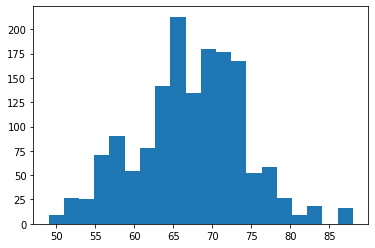

In [11]:
train_df['Age'].hist(grid=False, bins=20)

In [12]:
train_df


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Records
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,9
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,9
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,9
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,9
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,9
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,9
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,9
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,9
